# 1 Data preprocessing

In [38]:
import glob
import numpy as np
import os
import shutil
import PIL
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(42)

In [39]:
# Read all files from the fold 
_dataset_path = 'train/'
files = glob.glob(_dataset_path+"*")  #glob.glob is to extract the file into list

# save all cat images in cat_files

cat_files = []
dog_files = []

for f in files:
    fn = f.split('/')[-1].split('.')[0]
    if fn == 'cat':
        cat_files.append(f)
    elif fn == 'dog':
        dog_files.append(f)
    else:
        print("error:{}".format(f))

In [40]:
cat_files = np.array(cat_files)
dog_files = np.array(dog_files)

np.random.shuffle(cat_files)
np.random.shuffle(dog_files)

cat_train = cat_files[:1500]
cat_val = cat_files[1500:2000]
cat_test = cat_files[2000:2500]

dog_train = dog_files[:1500]
dog_val = dog_files[1500:2000]
dog_test = dog_files[2000:2500]
print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


## (2) copy selected subsets to folder

In [41]:
# Create directories
def create_folder(_fold_path):
    try:
        os.makedirs(_fold_path)
    except OSError:
        print("***folder already exist***")

In [42]:
_asset_path = 'asset/dog_cat/'

#named the directory of data set
train_dir = _asset_path+'training_data/'
val_dir = _asset_path+'validation_data/'
test_dir = _asset_path+'test_data/'

create_folder(train_dir)
create_folder(val_dir)
create_folder(test_dir)

***folder already exist***
***folder already exist***
***folder already exist***


In [43]:
# mix dog and cat
train_files = np.append(cat_train, dog_train)
validate_files = np.append(cat_val, dog_val)
test_files = np.append(cat_test, dog_test)

In [44]:
from shutil import copy2
def copy_to_dir(src_path, dst_path):
    for f in src_path:
        try:
            f_name = f.split("/")[-1]
            copy2(f,dst_path+f_name)
        except OSError:
            print("***{} already exist***".format(f))
    print("sucess")     
    return

In [45]:
# copy files to folder
copy_to_dir(train_files, train_dir)
copy_to_dir(validate_files, val_dir)
copy_to_dir(test_files, test_dir)

sucess
sucess
sucess


## (3) Build working dataset from selected files

In [46]:
# the input shape
IMG_DIM = (150, 150)

# To extract the samples from directory of train
train_files = glob.glob(train_dir+"*") 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in train_files]

# To extract the samples from directory of val
validation_files = glob.glob(val_dir+'*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation_files]

test_files = glob.glob(test_dir+'*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


### (4) convert category labels to integer

In [47]:
from sklearn.preprocessing import LabelEncoder
# encode labels
le = LabelEncoder()
le.fit(train_labels)
le.fit(validation_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'cat', 'dog', 'cat', 'cat'] [1 0 1 0 0]


### Rotate image,  Flip image, shear image, shit image

In [48]:
# To generate the sample from ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


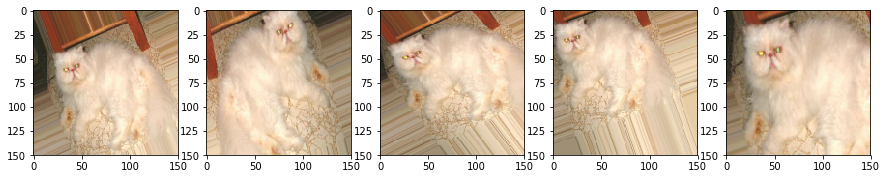

In [49]:
#To show the generated image which was desigened with ImageDataGenerator
img_id = 1991
temp_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
temp = [next(temp_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in temp])
l = [ax[i].imshow(temp[i][0][0]) for i in range(0,5)]

In [50]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

input_shape = (150, 150, 3)

# 2. VGG model without augmentation

![jupyter](https://cdn-images-1.medium.com/max/800/1*E7zhhan7Sp7hats4jkKdeA.png)

In [51]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255


batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

### To show the trainable params: 14,714,688, non-trainable params: 0


In [52]:
from keras.applications import vgg16
from keras.models import Model
import keras

# the VGG16 is pretrained model
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### To show the trainable params:0, non-trainable params: 14,714,688


In [53]:
# the last layer
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False  # The layer is not trainable

for layer in vgg_model.layers:
    layer.trainable = False # each layer is not trainable

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### To show the each layer whether can be trainable.

In [54]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f65d1c2cb70>,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0x7f65d1c2c550>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f65d1b07940>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f65e8167400>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f65e81675c0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f65e8171240>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f65d1ca6208>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f65d1ca63c8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f65d1f45908>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f65d1eb2588>,block3_conv3,False


(1, 4, 4, 512)


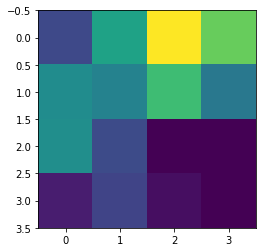

In [55]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [56]:
# the feature generated by the last layer of VGG16
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

### To extract the features from vgg model

In [57]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


### Designing our classfier with dropout

In [58]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


### Fitting the model

In [59]:
# To fit the model
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 3s 989us/step - loss: 0.4266 - acc: 0.7967 - val_loss: 0.3050 - val_acc: 0.8720
Epoch 2/30
3000/3000 [==============================] - 3s 898us/step - loss: 0.2889 - acc: 0.8770 - val_loss: 0.3485 - val_acc: 0.8300
Epoch 3/30
3000/3000 [==============================] - 3s 901us/step - loss: 0.2308 - acc: 0.9027 - val_loss: 0.2885 - val_acc: 0.8810
Epoch 4/30
3000/3000 [==============================] - 3s 941us/step - loss: 0.2010 - acc: 0.9190 - val_loss: 0.3026 - val_acc: 0.8770
Epoch 5/30
3000/3000 [==============================] - 3s 953us/step - loss: 0.1668 - acc: 0.9297 - val_loss: 0.2658 - val_acc: 0.8970
Epoch 6/30
3000/3000 [==============================] - 3s 942us/step - loss: 0.1409 - acc: 0.9443 - val_loss: 0.2771 - val_acc: 0.8990
Epoch 7/30
3000/3000 [==============================] - 3s 911us/step - loss: 0.1257 - acc: 0.9493 - val_loss: 0.2744 - val_acc: 0.9040


### Visualizing the performance

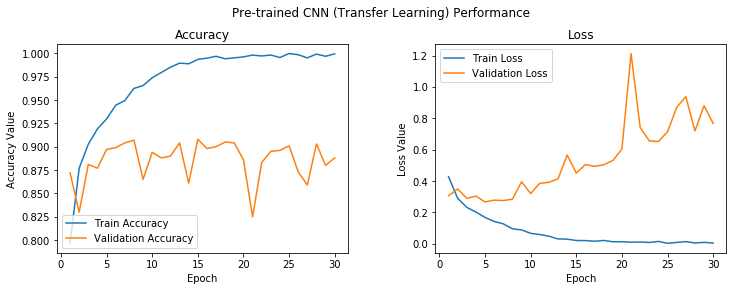

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [61]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

# VGG model with augmentation

### Defining the ImageDataGenerator

In [62]:

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [65]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers


input_shape = vgg_model.output_shape[1]

# model = Sequential()
# model.add(InputLayer(input_shape=(input_shape,)))
# model.add(Dense(512, activation='relu', input_dim=input_shape))
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_10 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
________________________________________________________

In [69]:
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=10,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/10
30/30 [==============================] - 109s 4s/step - loss: 0.5870 - acc: 0.6867 - val_loss: 0.4563 - val_acc: 0.8200
Epoch 2/10
30/30 [==============================] - 108s 4s/step - loss: 0.5553 - acc: 0.7156 - val_loss: 0.4362 - val_acc: 0.8220
Epoch 3/10
30/30 [==============================] - 108s 4s/step - loss: 0.5219 - acc: 0.7433 - val_loss: 0.4090 - val_acc: 0.8280
Epoch 4/10
30/30 [==============================] - 108s 4s/step - loss: 0.5123 - acc: 0.7478 - val_loss: 0.3978 - val_acc: 0.8200
Epoch 5/10
30/30 [==============================] - 108s 4s/step - loss: 0.5173 - acc: 0.7467 - val_loss: 0.3936 - val_acc: 0.8390
Epoch 6/10
30/30 [==============================] - 108s 4s/step - loss: 0.5085 - acc: 0.7444 - val_loss: 0.3716 - val_acc: 0.8310
Epoch 7/10
30/30 [==============================] - 109s 4s/step - loss: 0.4722 - acc: 0.7844 - val_loss: 0.3621 - val_acc: 0.8510
Epoch 8/10
30/30 [==============================] - 109s 4s/step - loss: 0.4900 - a

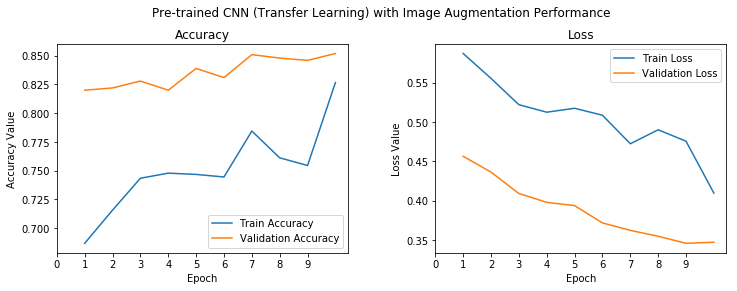

In [70]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0,10, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [48]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

# Fine tuning the parameters in the vgg model 

### Setting some layers in VGG can be trained

In [24]:
#vgg_model.trainable = True

#set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


In [36]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    else:
        set_trainable = False
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>, <tf.Variable 'block4_conv1/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32_ref>]


In [28]:
for layer in vgg_model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten_1


### Showing the each layer in VGG model

In [ ]:
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False  # The layer is not trainable

for layer in vgg_model.layers:
    layer.trainable = False # each layer is not trainable

In [34]:
vgg_model.trainable = False  # The layer is not trainable

for layer in vgg_model.layers:
    layer.trainable = False # each layer is not trainable

In [37]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f65ea0be550>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f663bee77f0>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f65e9cc19b0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f65e9c14668>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f65e9c14898>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f65e8394358>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f65e83ac518>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f65e83ac908>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f65e83622e8>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f65e837e320>,block3_conv3,False


In [62]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [63]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
________________________________________________________

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/30
100/100 [==============================] - 351s 4s/step - loss: 0.5916 - acc: 0.6757 - val_loss: 0.3077 - val_acc: 0.8780
Epoch 2/30
100/100 [==============================] - 352s 4s/step - loss: 0.3853 - acc: 0.8247 - val_loss: 0.2207 - val_acc: 0.9050
Epoch 3/30
100/100 [==============================] - 350s 4s/step - loss: 0.3307 - acc: 0.8563 - val_loss: 0.2042 - val_acc: 0.9200
Epoch 4/30
 90/100 [==========================>...] - ETA: 29s - loss: 0.3066 - acc: 0.8667

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 30, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Exercise 1 InceptionV3

![jupyter](https://cdn-images-1.medium.com/max/1200/1*gqKM5V-uo2sMFFPDS84yJw.png)

In [ ]:
# import layers
import glob
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, InputLayer
from keras import optimizers
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
# import InveptionV3 model
inception_base = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
inception_base.summary()
pixel_branch = inception_base.output
pixel_branch = Flatten()(pixel_branch)

new_model_inception = Model(inputs=inception_base.input, outputs=pixel_branch)
new_model_inception.trainable = False

for layer in new_model_inception.layers:
    layer.trainable = False

In [ ]:
# Defining the function of get_bottle_features
def get_bottle_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features


In [ ]:
#Extracting the fatures using function
train_features_inception = get_bottle_features(new_model_inception, train_imgs_scaled)
validation_features_inception = get_bottle_features(new_model_inception, validation_imgs_scaled)

In [ ]:
input_shape = new_model_inception.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape = (input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(x=train_features_inception,
                    y=train_labels_enc,
                    validation_data=(validation_features_inception, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

# Exercise 2 VGG19

![jupyter](https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg)

In [10]:
# import layers
from keras.applications.vgg19 import VGG19

In [ ]:
# read the file
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, '\tValidation dataset shape:', validation_imgs.shape)



le = LabelEncoder()
le.fit(train_labels)
# encode  labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [ ]:
train_imgs_scaled = train_imgs.astype('float32')

validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)



le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

In [ ]:
VGG19_base = VGG19(input_shape=input_shape, weights='imagenet', include_top=False)
VGG19_base.summary()
pixel_branch = VGG19_base.output
pixel_branch = Flatten()(pixel_branch)

new_model_vgg19 = Model(inputs=VGG19_base.input, outputs=pixel_branch)
new_model_vgg19.trainable = False

for layer in new_model_vgg19.layers:
    layer.trainable = False

In [ ]:
train_features_vgg19 = get_bottle_features(new_model_vgg19, train_imgs_scaled)
validation_features_vgg19 = get_bottle_features(new_model_vgg19, validation_imgs_scaled)

In [ ]:
input_shape = new_model_vgg19.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape = (input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(x=train_features_vgg19,
                    y=train_labels_enc,
                    validation_data=(validation_features_vgg19, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)